## Importing all the necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

--2025-09-30 09:28:53--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0.001s  

2025-09-30 09:28:53 (16.2 MB/s) - ‘helper_prabowo_ml.py’ saved [13881/13881]



In [3]:
!pip install transformers

In [4]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

2025-09-30 09:28:59.299487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759224539.499426      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759224539.556321      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the train, validation and test datasets

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eftekhar/bangla-textual-emotion-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bangla-textual-emotion-dataset


In [6]:
!ls /root/.cache/kagglehub/datasets/eftekhar/bangla-textual-emotion-dataset/versions/1

ls: cannot access '/root/.cache/kagglehub/datasets/eftekhar/bangla-textual-emotion-dataset/versions/1': No such file or directory


In [7]:
import pandas as pd
train_xlsx = pd.read_excel("/kaggle/input/bangla-textual-emotion-dataset/train_emotion.xlsx")
test = pd.read_excel("/kaggle/input/bangla-textual-emotion-dataset/test_emotion.xlsx")

# Split the training data to create a validation set (20%)
train, val = train_test_split(train_xlsx, test_size=0.2, random_state=42, shuffle=True, stratify=train_xlsx['classes'])

print("Shape of train_xlsx:", train.shape)
print("Shape of val_xlsx:", val.shape)
print("Shape of test_xlsx:", test.shape)

Shape of train_xlsx: (21088, 2)
Shape of val_xlsx: (5273, 2)
Shape of test_xlsx: (2929, 2)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21088 entries, 23337 to 25920
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TEXT     21088 non-null  object
 1   classes  21088 non-null  object
dtypes: object(2)
memory usage: 494.2+ KB


In [9]:
train = train.rename(columns={'TEXT': 'Input'})
val = val.rename(columns={'TEXT': 'Input'})
test = test.rename(columns={'TEXT': 'Input'})

train = train.rename(columns={'classes': 'Sentiment'})
val = val.rename(columns={'classes': 'Sentiment'})
test = test.rename(columns={'classes': 'Sentiment'})

print(train.columns)
print(val.columns)
print(test.columns)

Index(['Input', 'Sentiment'], dtype='object')
Index(['Input', 'Sentiment'], dtype='object')
Index(['Input', 'Sentiment'], dtype='object')


In [10]:
print(train_xlsx.columns)

Index(['TEXT', 'classes'], dtype='object')


In [11]:
#data preprocessing using spacy

#removing unnecessary punctuation
import re

# Data cleaning function
def process_comments(Comment):
    Comment = re.sub('[^\u0980-\u09FF]',' ',str(Comment)) #removing unnecessary punctuation
    return Comment

train['Input'] = train['Input'].apply(process_comments)
test['Input'] = test['Input'].apply(process_comments)
val['Input'] = val['Input'].apply(process_comments)

print(train.info())
print(test.info())
print(val.info())


<class 'pandas.core.frame.DataFrame'>
Index: 21088 entries, 23337 to 25920
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Input      21088 non-null  object
 1   Sentiment  21088 non-null  object
dtypes: object(2)
memory usage: 494.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Input      2929 non-null   object
 1   Sentiment  2929 non-null   object
dtypes: object(2)
memory usage: 45.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 5273 entries, 24895 to 25037
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Input      5273 non-null   object
 1   Sentiment  5273 non-null   object
dtypes: object(2)
memory usage: 123.6+ KB
None


In [12]:
import pandas as pd

# Load Bengali stop words from a CSV file
stop_words_df = pd.read_csv('/kaggle/input/bangla-stopwords/stopwords_bangla.csv')  # Assuming the CSV has one column with stop words
stop_words_df=stop_words_df.drop(['Unnamed: 0'], axis=1)
# Convert the stop words to a list
stop_words_list = stop_words_df.iloc[:, 0].tolist()  # Convert the column to a list

# Check the stop words list
print("Stop words list:", stop_words_list[:10])  # Print first 10 stop words for verification


# Function to remove stop words
def remove_stop_words(text, stop_words):
    if isinstance(text, str):  # Ensure the text is a string
        # Tokenize text (simple split for Bengali)
        words = text.split()
        # Filter out stop words
        filtered_words = [word for word in words if word not in stop_words]
        # Join words back into a single string
        return ' '.join(filtered_words)
    else:
        return text  # If text is not a string, return it as is

# Assuming 'df' is the DataFrame and 'Cleaned' is the column with text data
# Check a few entries in the original DataFrame
print("Original texts:", train['Input'].head())

# Apply the function to the DataFrame
train['Input'] = train['Input'].apply(lambda x: remove_stop_words(x, stop_words_list))




Stop words list: ['অই', 'অগত্যা', 'অত: পর', 'অতএব', 'অথচ', 'অথবা', 'অধিক', 'অধীনে', 'অধ্যায়', 'অনুগ্রহ']
Original texts: 23337    শান্তনু আর শর্মিলাদের দেখাদেখি এই রোবোট মেইডকে...
14226    বান্দরবানের লামায় বন্যহাতির পায়ে পিষ্ট হয়ে নুর...
10081    আমি আপনারা খুব সুবিধা পেয়েছেন এবং আমি আশা করি...
6588     আমি লেখার থেকে দীর্ঘ বিরতি নেওয়ার সময় অস্থির...
22682          অসুস্থ বোধ কম বোঝা এবং বিভ্রান্ত দীর্ঘশ্বাস
Name: Input, dtype: object


In [13]:
train.iloc[0].Input

'শান্তনু শর্মিলাদের দেখাদেখি রোবোট মেইডকে ঘরে এনে যন্ত্রণা শান্তি যন্ত্রের যন্ত্রণা থুড়ি যন্ত্রিনীর যন্ত্রণা'

In [14]:
# train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
# val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
# test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

## Combining the train, validation and test datasets into a single dataframe

In [15]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=1)
df = df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29290 entries, 0 to 29289
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      29290 non-null  int64 
 1   Input      29290 non-null  object
 2   Sentiment  29290 non-null  object
dtypes: int64(1), object(2)
memory usage: 686.6+ KB


In [16]:
df.drop('index',axis=1,inplace=True)

In [17]:
df.shape

(29290, 2)

## Text Preprocessing

In [18]:
# def preprocess_data(data,col):
#     data[col] = data[col].apply(func=clean_html)
#     data[col] = data[col].apply(func=remove_digits)
#     data[col] = data[col].apply(func=remove_)
#     data[col] = data[col].apply(func=removeStopWords)
#     data[col] = data[col].apply(func=remove_links)
#     data[col] = data[col].apply(func=remove_special_characters)
#     data[col] = data[col].apply(func=non_ascii)
#     data[col] = data[col].apply(func=email_address)
#     data[col] = data[col].apply(func=punct)
#     data[col] = data[col].apply(func=lower)
#     return data

In [19]:
# preprocessed_df = preprocess_data(df,'Input')
# preprocessed_df.head()

In [20]:
df['num_words'] = df.Input.apply(len)

In [21]:
df.head()

,Input,Sentiment,num_words
0,তৃতীয় চাকরিতে সন্ধ্যা না বাড়িতে থাকতে না পার...,sadness,83
1,ঘুরে আসবে পুরনো গুলো অতীত জয়ধ্বনির পাবে জয়ধ্বন...,joy,190
2,ছায়ারা ইউনুস সাথে মজা উবু ছেড়েছে পথে সঠিক পথ...,surprise,59
3,সেদিন হাঁপাতে হাঁপাতে রুমে ঢুকলো চুলগুলো এলোমে...,fear,84
4,বিশ্রী মুহূর্তটি আপনাকে পিঠে ছুরিকাঘাত জানেন না,surprise,47


In [22]:
print(df['Sentiment'].unique())

['sadness' 'joy' 'surprise' 'fear' 'anger' 'disgust']


In [23]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'disgust': 3, 'sadness': 4, 'surprise': 5}

## Train-Test Split

In [24]:
train_data, test_data = train_test_split(df,test_size=0.3,random_state=101,shuffle=True,stratify=df.Sentiment)

## Loading the Tokenizer class and pretrained BERT model

In [25]:
!rm -rf ~/.cache/huggingface/

In [26]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
# bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased",from_pt=True)

# Add other models and tokenizers here
# tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
# bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased",from_pt=True)

# You can add more models here and uncomment the one you want to use
# tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
# bert_model = TFBertModel.from_pretrained("xlm-roberta-base", from_pt=True)
# tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert_small")
# model = TFAutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglabert_small")


tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
bert_model = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base", from_pt=True)

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/660M [00:00<?, ?B/s]

I0000 00:00:1759224569.651254      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759224569.651908      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClas

In [27]:
!rm -rf ~/.cache/huggingface/

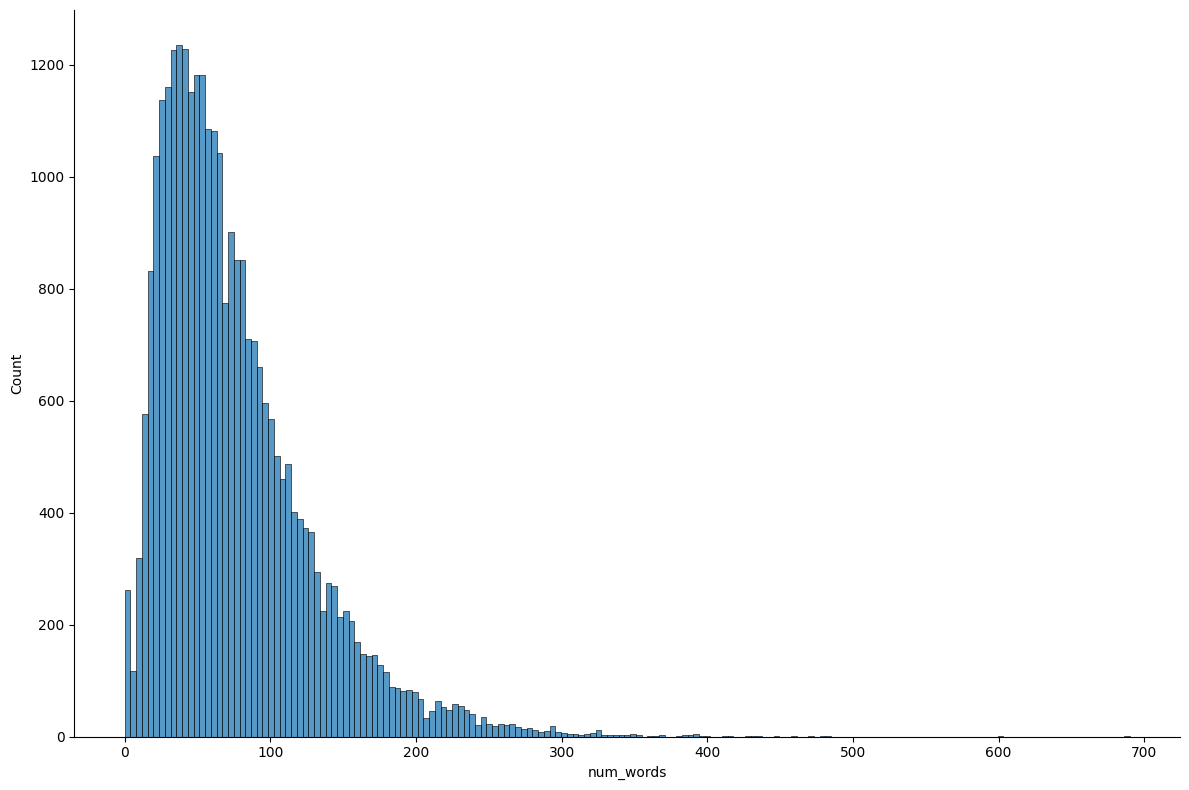

In [28]:
sns.displot(df.num_words,height=8,aspect=1.5)

In [29]:
max_len = 64

## Text Tokenization

In [30]:
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [31]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [32]:
# embeddings = bert_model([input_ids, attention_mask])[0] # 0: final hidden state, 1: pooling output
# output = GlobalMaxPool1D()(embeddings)
# output = Dense(units=128,activation='relu')(output)
# output = Dropout(0.1)(output)
# output = Dense(units=64,activation='relu')(output)
# output = Dense(units=32,activation='relu')(output)
# y = Dense(units=6,activation='softmax')(output)

# model = Model(inputs=[input_ids,attention_mask],outputs=y)
# model.layers[2].trainable = True

In [34]:
import tensorflow as tf
from transformers import TFBertModel
from tensorflow.keras.layers import Input, GlobalMaxPool1D, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Load BERT (convert from PyTorch weights if needed)
bert_model = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base", from_pt=True)
#bert_model = TFAutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglabert_small", from_pt=True)

# Define Keras Input layers
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Wrap BERT in Lambda with explicit output shape
def bert_encode(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.last_hidden_state   # [batch, seq_len, hidden]

embeddings = Lambda(
    bert_encode,
    output_shape=(max_len, 768)   # seq_len=max_len, hidden=768 for bert-base-multilingual-cased
)([input_ids, attention_mask])

# Add custom layers
x = GlobalMaxPool1D()(embeddings)
x = Dense(512, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
y = Dense(6, activation="softmax")(x)

# Build model
model = Model(inputs=[input_ids, attention_mask], outputs=y)

# Make BERT trainable
bert_model.trainable = True

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [35]:
# import tensorflow as tf
# from transformers import TFXLMRobertaModel
# from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # --------------------------
# # 1. Hyperparameters
# # --------------------------
# max_len = 64          # sequence length
# num_classes = 6       # number of emotion classes
# dropout_rate = 0.3
# learning_rate = 2e-5  # recommended for fine-tuning XLM-R/BERT

# # --------------------------
# # 2. Load XLM-RoBERTa
# # --------------------------
# bert_model = TFXLMRobertaModel.from_pretrained("xlm-roberta-base", from_pt=True)
# bert_model.trainable = True  # allow fine-tuning

# # --------------------------
# # 3. Define Inputs
# # --------------------------
# input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
# attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# # --------------------------
# # 4. CLS token embedding
# # --------------------------
# def get_cls_embedding(inputs):
#     ids, mask = inputs
#     outputs = bert_model(input_ids=ids, attention_mask=mask)
#     return outputs.pooler_output  # shape: [batch, hidden=768]

# cls_output = Lambda(get_cls_embedding, output_shape=(768,))([input_ids, attention_mask])

# # --------------------------
# # 5. Classification Head
# # --------------------------
# x = Dropout(dropout_rate)(cls_output)
# x = Dense(256, activation="relu")(x)
# x = Dropout(dropout_rate)(x)
# x = Dense(128, activation="relu")(x)
# x = Dropout(dropout_rate)(x)
# output = Dense(num_classes, activation="softmax")(x)

# # --------------------------
# # 6. Build Model
# # --------------------------
# model = Model(inputs=[input_ids, attention_mask], outputs=output)

# # --------------------------
# # 7. Compile Model
# # --------------------------
# optimizer = Adam(learning_rate=learning_rate, epsilon=1e-8)
# model.compile(optimizer=optimizer,
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

# model.summary()


## Compiling the model

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

model.compile(
    loss=CategoricalCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate=5e-5, epsilon=1e-8, clipnorm=1.0),
    metrics=[CategoricalAccuracy(name="accuracy")]
)

## Encoding the emotion labels

In [37]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [38]:
train_data.head()

,Input,Sentiment,num_words,Label
16373,পর্যায়ে বাকবিতন্ডায় জড়িয়ে ক্ষুব্ধ বৈধ লাইসেন্স...,anger,114,0
6095,আমি কাল সকালে খুব উত্তেজিত,surprise,27,5
14708,,surprise,0,5
20560,মা অগ্রণীকরণে রেখেছিলেন,anger,23,0
21654,অপ্রীতিকর বিস্ময়ের রয়েছেন,sadness,27,4


In [39]:
test_data.head()

,Input,Sentiment,num_words,Label
2827,ভিয়েতনামকে ৩০ আগের দেশটিকে চেনা দায় বিশ্বের অন...,surprise,99,5
23823,হাপ্পা ইগ্রোনন্ডে সমস্ত কিছু মিস করেছ...,surprise,120,5
2076,আমি আমার খাদ্যনালীতে এমন কিছু জমা দিয়েছি যা এ...,joy,81,2
10252,জিতে,surprise,4,5
10668,সাথে কথা চাই ফোনে সীমিত বিন্যাসের সাথে আনতে দ্...,fear,54,1


## Generating the model summary and plot

In [40]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 768)   │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 768)       │          0 │ lambda_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    393,728 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 6)         │        390 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 566,598 (2.16 MB)

 Trainable params: 566,598 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

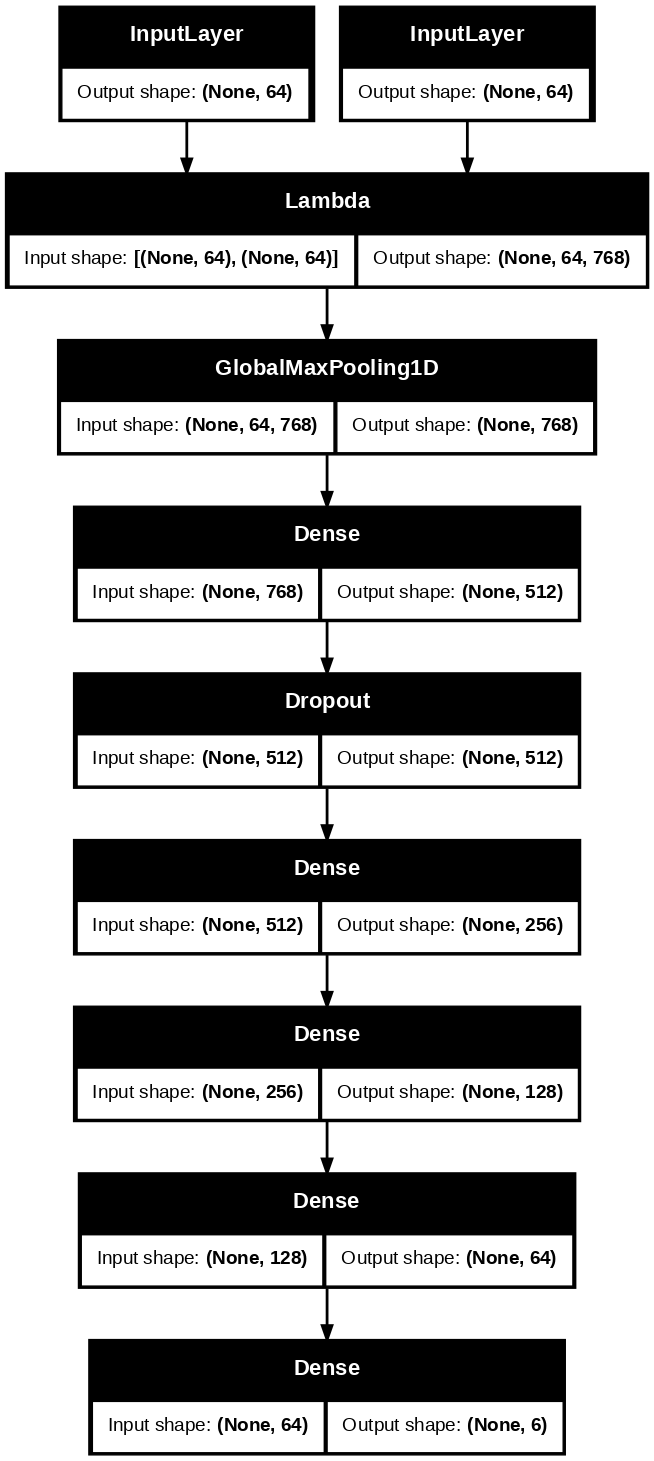

In [41]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

## Training and fine-tuning the pretrained BERT model

In [42]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=30,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/30


I0000 00:00:1759224617.951738     109 service.cc:148] XLA service 0x796640004530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759224617.952183     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759224617.952203     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1759224618.483748     109 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1759224620.395641     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/641 ━━━━━━━━━━━━━━━━━━━━ 4:04:58 23s/step - accuracy: 0.0312 - loss: 3.4339

I0000 00:00:1759224623.942063     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


640/641 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2901 - loss: 1.7103

W0000 00:00:1759224701.285964     108 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert


641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2901 - loss: 1.7101

W0000 00:00:1759224710.247927     111 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1759224750.059746     108 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert


641/641 ━━━━━━━━━━━━━━━━━━━━ 151s 200ms/step - accuracy: 0.2902 - loss: 1.7099 - val_accuracy: 0.3910 - val_loss: 1.4890
Epoch 2/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 121s 189ms/step - accuracy: 0.3865 - loss: 1.4946 - val_accuracy: 0.4277 - val_loss: 1.4315
Epoch 3/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 122s 190ms/step - accuracy: 0.4221 - loss: 1.4410 - val_accuracy: 0.4460 - val_loss: 1.4047
Epoch 4/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 121s 189ms/step - accuracy: 0.4489 - loss: 1.3844 - val_accuracy: 0.4435 - val_loss: 1.3851
Epoch 5/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 121s 189ms/step - accuracy: 0.4599 - loss: 1.3639 - val_accuracy: 0.4602 - val_loss: 1.3640
Epoch 6/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 121s 189ms/step - accuracy: 0.4710 - loss: 1.3316 - val_accuracy: 0.4731 - val_loss: 1.3308
Epoch 7/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 122s 190ms/step - accuracy: 0.4833 - loss: 1.3077 - val_accuracy: 0.4838 - val_loss: 1.3205
Epoch 8/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 121s 189ms/step - accuracy: 0.4917 - loss: 1.30

## Analyzing model performance

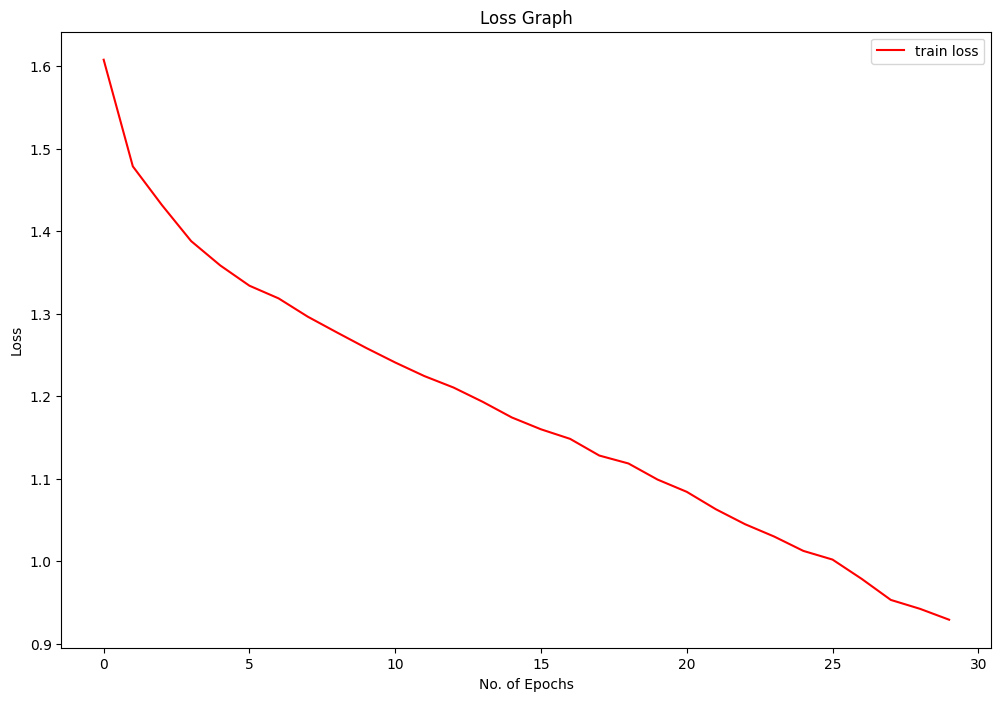

In [43]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

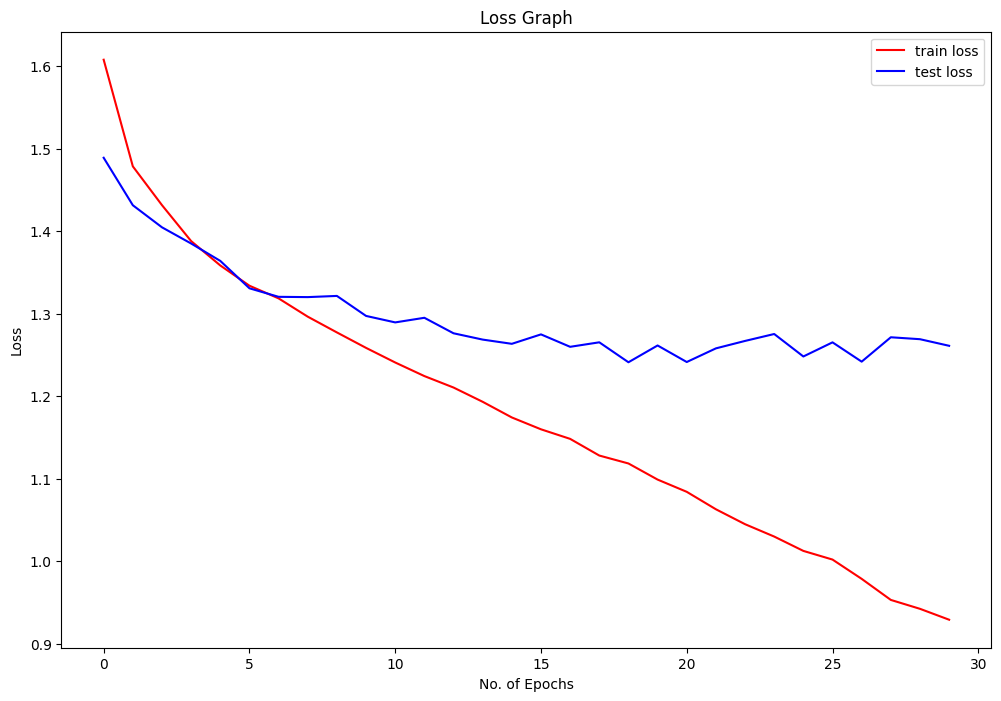

In [44]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

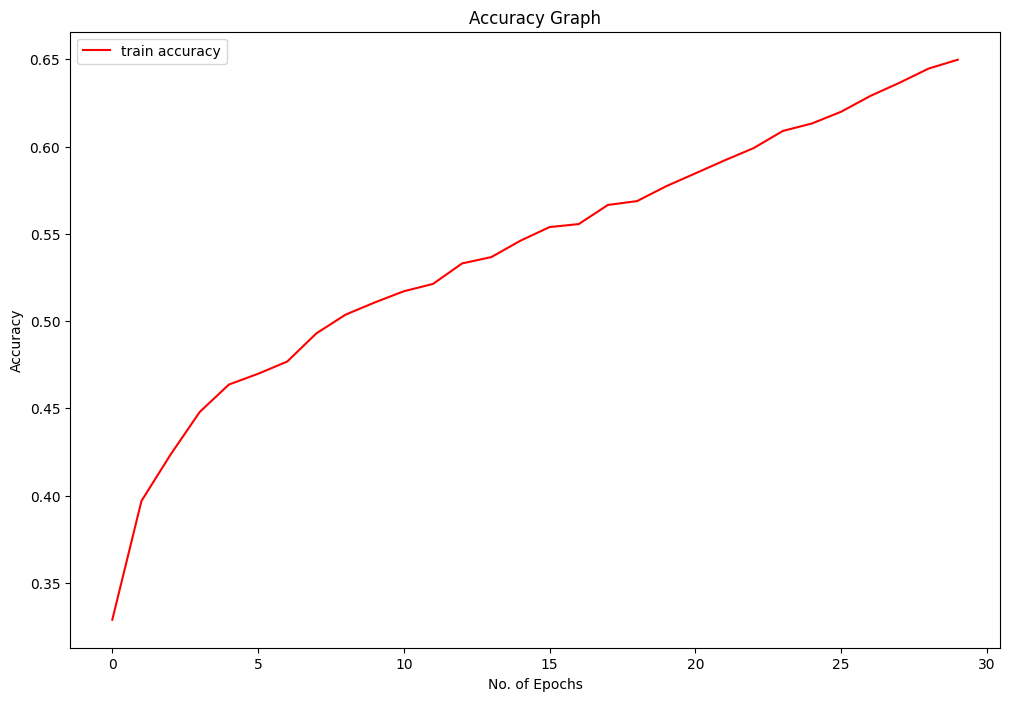

In [45]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

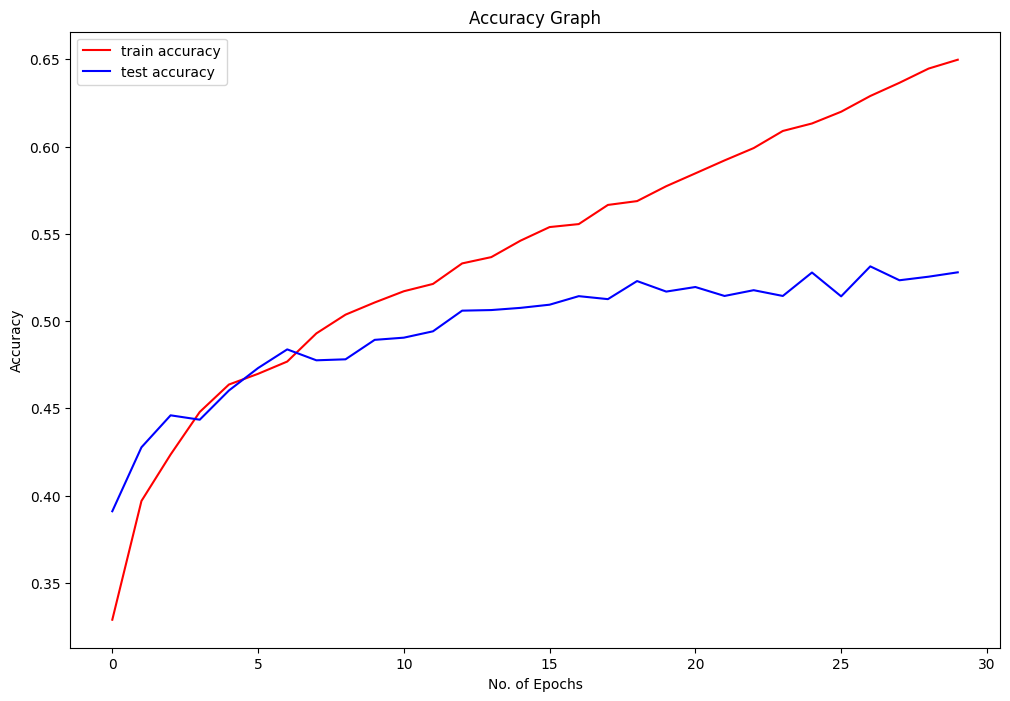

In [46]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [47]:
model.save("emotion_detector_e30_f100_acc65_Bangla.h5")

## Evaluating the model on the test dataset

In [48]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

275/275 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - accuracy: 0.5330 - loss: 1.2670
Test Categorical Cross-Entropy Loss: 1.261160135269165
Test Categorical Accuracy: 0.5279390215873718


In [49]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

W0000 00:00:1759228350.553578     109 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert


274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

W0000 00:00:1759228391.421559     108 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert


275/275 ━━━━━━━━━━━━━━━━━━━━ 45s 150ms/step
              precision    recall  f1-score   support

           0       0.45      0.19      0.27      1040
           1       0.49      0.36      0.41       910
           2       0.51      0.68      0.58      2371
           3       0.64      0.60      0.62       782
           4       0.50      0.48      0.49      2096
           5       0.58      0.64      0.61      1588

    accuracy                           0.53      8787
   macro avg       0.53      0.49      0.50      8787
weighted avg       0.52      0.53      0.51      8787



The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.

In [311]:
for layer in bert_model.layers:
    print(layer.trainable)  # should be True


True
